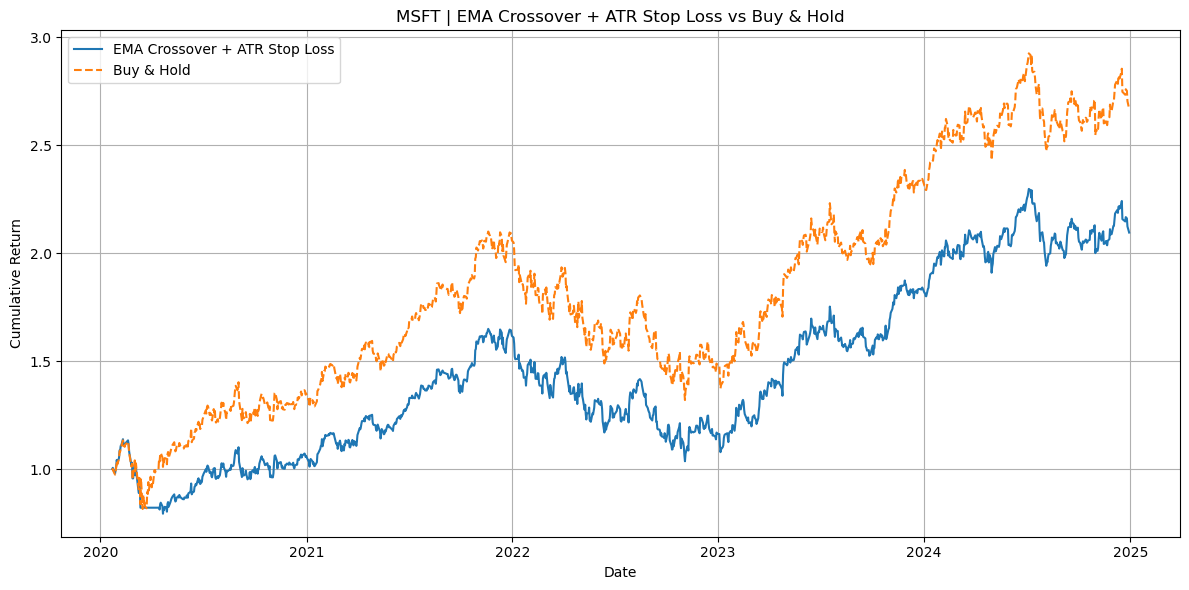


MSFT | Basic EMA Crossover + ATR Stop Loss Metrics:
Total Return (%): 109.52
Annualized Volatility (%): 27.78
Sharpe Ratio: 0.68
Max Drawdown (%): -37.15

MSFT | Buy & Hold Metrics:
Total Return (%): 166.76
Annualized Volatility (%): 30.61
Sharpe Ratio: 0.80
Max Drawdown (%): -37.15


In [1]:
# === BASIC EMA CROSSOVER + ATR STOP LOSS STRATEGY ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# === PARAMETERS ===
try:
    ticker
except NameError:
    ticker = 'MSFT'  # default value if not passed via papermill
start_date = '2020-01-01'
end_date = '2024-12-31'

# === 1. Download data ===
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
data = data[['Close', 'High', 'Low']].copy()

# === 2. Indicators ===
data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()

# === 3. ATR (14-day) ===
tr1 = data['High'] - data['Low']
tr2 = (data['High'] - data['Close'].shift()).abs()
tr3 = (data['Low'] - data['Close'].shift()).abs()
data['TR'] = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
data['ATR'] = data['TR'].rolling(window=14).mean()

# === 4. Entry signals ===
data['Signal'] = 0
data.loc[data['EMA_10'] > data['EMA_50'], 'Signal'] = 1
data['Position'] = data['Signal'].shift(1)

# === 5. ATR-based Stop Loss ===
atr_multiplier = 2
adjusted_position = []
in_position = False
entry_price = 0.0
stop_price = 0.0

for i in range(len(data)):
    close_price = data['Close'].iloc[i].item()
    atr_value = data['ATR'].iloc[i]

    if not in_position:
        if data['Position'].iloc[i] == 1 and not np.isnan(atr_value):
            in_position = True
            entry_price = close_price
            stop_price = entry_price - atr_multiplier * atr_value
            adjusted_position.append(1)
        else:
            adjusted_position.append(0)
    else:
        if close_price < stop_price:
            in_position = False
            entry_price = 0.0
            stop_price = 0.0
            adjusted_position.append(0)
        else:
            adjusted_position.append(1)

data['Adj_Position'] = adjusted_position

# === 6. Returns ===
data['Daily Return'] = data['Close'].pct_change()
data['Strategy Return'] = data['Adj_Position'].shift(1) * data['Daily Return']
data.dropna(inplace=True)

# === 7. Plot performance ===
cumulative = (1 + data['Strategy Return']).cumprod()
cumulative_bh = (1 + data['Daily Return']).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(cumulative, label='EMA Crossover + ATR Stop Loss')
plt.plot(cumulative_bh, label='Buy & Hold', linestyle='--')
plt.title(f'{ticker} | EMA Crossover + ATR Stop Loss vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{ticker.lower()}_ema_atr_sl_strategy.png", dpi=300, bbox_inches='tight')
plt.show()

# === 8. Performance metrics ===
def compute_metrics(returns):
    total_return = (1 + returns).prod() - 1
    annual_vol = returns.std() * np.sqrt(252)
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)
    cumulative = (1 + returns).cumprod()
    drawdown = cumulative / cumulative.cummax() - 1
    max_dd = drawdown.min()
    return {
        'Total Return (%)': total_return * 100,
        'Annualized Volatility (%)': annual_vol * 100,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown (%)': max_dd * 100
    }

metrics = compute_metrics(data['Strategy Return'])
buyhold = compute_metrics(data['Daily Return'])

print(f"\n{ticker} | Basic EMA Crossover + ATR Stop Loss Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.2f}")

print(f"\n{ticker} | Buy & Hold Metrics:")
for k, v in buyhold.items():
    print(f"{k}: {v:.2f}")

In [2]:
# Parameters
ticker = "MSFT"
